# 데이터 불러오기

In [ ]:
!pip install konlpy

     |████████████████████████████████| 19.4 MB 6.4 MB/s 
     |████████████████████████████████| 448 kB 48.4 MB/s 


In [ ]:
import os

import numpy as np
import pandas as pd

from datetime import datetime
import json
import re

from konlpy.tag import Okt # komoran, han, kkma

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence

from tqdm.notebook import tqdm

In [ ]:
df_1 = pd.read_csv('/content/2021_1분기.csv', index_col = 0)
df_2 = pd.read_csv('/content/2021_2분기.csv', index_col = 0)
df_3 = pd.read_csv('/content/2021_3분기.csv', index_col = 0)
df_4 = pd.read_csv('/content/2021_4분기.csv', index_col = 0)

In [ ]:
df_1 = df_1.reset_index(drop=True)
df_1 = df_1.drop('Unnamed: 0.1', axis=1)
df_1 = df_1.rename(columns={'total_reivew' : 'total_review'})

df_2 = df_2.reset_index(drop=True)
df_2 = df_2.drop('Unnamed: 0.1', axis=1)
df_2 = df_2.rename(columns={'total_reivew' : 'total_review'})

df_3 = df_3.reset_index(drop=True)
df_3 = df_3.drop('Unnamed: 0.1', axis=1)
df_3 = df_3.rename(columns={'total_reivew' : 'total_review'})

df_4 = df_4.reset_index(drop=True)
df_4 = df_4.drop('Unnamed: 0.1', axis=1)
df_4 = df_4.rename(columns={'total_reivew' : 'total_review'})

# 큐레이팅 불용어 사전 만들기

In [ ]:
df_all_quarter = pd.read_csv('/content/all_quarter.csv', index_col = 0)

In [ ]:
df_all_quarter['0']

0       팬츠
1       스웨
2      포인트
3      스타일
4      실루엣
5       셔츠
6       활용
7       재킷
8      티셔츠
9      그래픽
10      데님
11      후드
12      주얼
13      패턴
14      블랙
15     디테일
16    스니커즈
17     브랜드
18      니트
19     클래식
20      사용
21     트렌디
22     유니크
23      심플
24     베이식
25      모두
26      라면
27      포켓
28      겨울
29      셋업
30      빈티
31      디테
32      기본
33     스트릿
34      반스
35      요즘
36      레더
37     와이드
38      블루
39    아디다스
40     카디건
41     그레이
42     슬랙스
43      기분
44      녀석
45      가방
46     화이트
47     레이어
48     NaN
Name: 0, dtype: object

In [ ]:
one_words = df_all_quarter['0'].tolist()
one_words = [x for x in one_words if pd.isna(x) != True ]

two_words = df_all_quarter['0.1'].tolist()
two_words = [x for x in two_words if pd.isna(x) != True ]

thr_words = df_all_quarter['0.2'].tolist()
thr_words = [x for x in thr_words if pd.isna(x) != True ]
  
fou_words = df_all_quarter['0.3'].tolist()
fou_words = [x for x in fou_words if pd.isna(x) != True ]

print(len(one_words), len(two_words), len(thr_words), len(fou_words))

48 41 46 49


In [ ]:
df_word_count = pd.read_csv('/content/1분기단어.csv', index_col = 0)
df_word_count2 = pd.read_csv('/content/2분기단어.csv', index_col = 0)
df_word_count3 = pd.read_csv('/content/3분기단어.csv', index_col = 0)
df_word_count4 = pd.read_csv('/content/4분기단어.csv', index_col = 0)

In [ ]:
fir_words_list = df_word_count['단어'].tolist()
sec_words_list = df_word_count2['단어'].tolist()
thr_words_list = df_word_count3['단어'].tolist()
fou_words_list = df_word_count4['단어'].tolist()

In [ ]:
first_words = [x for x in fir_words_list if x not in sec_words_list]
first_words = [x for x in first_words if x not in thr_words_list]
first_words = [x for x in first_words if x not in fou_words_list]
len(first_words)

731

In [ ]:
second_words = [x for x in sec_words_list if x not in fir_words_list]
second_words = [x for x in second_words if x not in thr_words_list]
second_words = [x for x in second_words if x not in fou_words_list]
len(second_words)

792

In [ ]:
third_words = [x for x in thr_words_list if x not in fir_words_list]
third_words = [x for x in third_words if x not in sec_words_list]
third_words = [x for x in third_words if x not in fou_words_list]
len(third_words)

746

In [ ]:
fourth_words = [x for x in fou_words_list if x not in fir_words_list]
fourth_words = [x for x in fourth_words if x not in sec_words_list]
fourth_words = [x for x in fourth_words if x not in thr_words_list]
len(fourth_words)

907

In [ ]:
one_stopwords = [x for x in df_word_count['단어'] if x not in first_words]
two_stopwords = [x for x in df_word_count2['단어'] if x not in second_words]
thr_stopwords = [x for x in df_word_count3['단어'] if x not in third_words]
fou_stopwords = [x for x in df_word_count4['단어'] if x not in fourth_words]
print(len(one_stopwords), len(two_stopwords), len(thr_stopwords), len(fou_stopwords))

2668 2767 2782 2754


In [ ]:
stopwords = [one_stopwords, two_stopwords, thr_stopwords, fou_stopwords]

# 상품상세설명 불용어 사전 만들기

In [ ]:
df_product = pd.read_csv('/content/불용어 제거한 상세설명_.csv', index_col = 0)

# 결측치 제거
df_product = df_product.dropna()
df_product = df_product.reset_index(drop=True)

# 중복 제거
df_product = df_product.drop_duplicates(['상품설명'], ignore_index = True)
df_product

,상품번호,상품설명
0,1149328,편안하면서도 슬림한 테이퍼드 핏의 히든 밴딩 크롭 슬랙스의 폴리우레탄이 포함된 양방...
1,1220731,베이식한 디자인의 사피아노 신세틱 레더 벨트포멀 룩부터 캐주얼 룩까지 다양하게 활용...
2,1149329,여유 있는 실루엣의 세미 와이드 핏 히든 밴딩 슬랙스의 폴리우레탄이 포함된 양방향 ...
3,996177,여유 있는 릴렉스 핏의 크루 넥 티셔츠촘촘하게 짜여진 면 코마사 수 싱글 저지 원...
4,1144989,여유 있는 릴렉스 핏의 베이식 롱 슬리브 티셔츠촘촘하게 짜여진 면 코마사 수 싱글...
...,...,...
831,2392480,베이식한 디자인의 우먼즈 스웨트 맥시 스커트 촘촘하게 짜인 면 프렌치 테리 원단을...
832,2392463,여유 있는 릴렉스 핏의 우먼즈 스웨트 쇼츠촘촘하게 짜인 면 프렌치 테리 원단을 사...
833,2356369,넉넉한 핏의 오버사이즈 더블 포켓 데님 셔츠 의 적당한 중량과 두께의 원단으로 한여...
834,2341477,베이식한 디자인의 쿨탠다드 릴렉스드 슬리브리스 탑세계적인 기능성 원사원단 업체인 효...


In [ ]:
product_stopwords = ['원단', '사용', '착용', '실루엣', '디자인', '가공', '구성', '적용', '활용', '제품', '제공', '용도', '사이즈', '아이템', '완성', '공정', '포면', '구조', '위해', '가지', '포함', '연출', '형태',
                 '일리', '컬러', '제작', '보장', '소재', '이용', '일반', '단계', '덕분', '부위', '사양', '방식', '통해', '추가']


# 큐레이팅 - 상품설명 합치기

In [ ]:
curating_1 = ''.join(df_1['total_review'].tolist())
curating_2 = ''.join(df_2['total_review'].tolist())
curating_3 = ''.join(df_3['total_review'].tolist())
curating_4 = ''.join(df_4['total_review'].tolist())

In [ ]:
df_curating_1 = pd.DataFrame([['큐레이팅', curating_1]], columns=['상품번호', '상품설명'])
df_curating_2 = pd.DataFrame([['큐레이팅', curating_2]], columns=['상품번호', '상품설명'])
df_curating_3 = pd.DataFrame([['큐레이팅', curating_3]], columns=['상품번호', '상품설명'])
df_curating_4 = pd.DataFrame([['큐레이팅', curating_4]], columns=['상품번호', '상품설명'])

In [ ]:
df_curating_11 = pd.concat([df_curating_1, df_product])
df_curating_22 = pd.concat([df_curating_2, df_product])
df_curating_33 = pd.concat([df_curating_3, df_product])
df_curating_44 = pd.concat([df_curating_4, df_product])

df_curating_11 = df_curating_11.reset_index(drop=True)
df_curating_22 = df_curating_22.reset_index(drop=True)
df_curating_33 = df_curating_33.reset_index(drop=True)
df_curating_44 = df_curating_44.reset_index(drop=True)

# 각 데이터프레임별로 tf-idf 진행

1분기

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import requests
from bs4 import BeautifulSoup

import warnings
warnings.filterwarnings('ignore')

In [ ]:
def get_title(num):
  url = 'https://www.musinsa.com/app/goods/'+str(num)
  headers = {
      'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/100.0.4896.57 Whale/3.14.133.23 Safari/537.36'
  }
  resp = requests.get(url, headers=headers)
  soup = BeautifulSoup(resp.text)
  title_tags = soup.select('#page_product_detail > div.right_area.page_detail_product > div.right_contents.section_product_summary > span > em')

  title = title_tags[0].text

  return title

def text_cleaning(text, stopwords):
    hangul = re.compile('[^ ㄱ-ㅣ 가-힣]')  # 정규 표현식 처리
    result = hangul.sub('', text)
    okt = Okt()  # 형태소 추출
    nouns = okt.nouns(result)
    nouns = [x for x in nouns if len(x) > 1]  # 한글자 키워드 제거
    
    if len(text) > 10000:
      nouns = [x for x in nouns if x not in stopwords]
    else:
      nouns = [x for x in nouns if x not in product_stopwords]
    return nouns

def vect_count(data1, num):
    tfidf = TfidfVectorizer(tokenizer = lambda x: text_cleaning(x, stopwords[num]), max_features=300, min_df=20, max_df=0.2)
    tf_idf_vect = tfidf.fit_transform(data1['상품설명'])
    tf_idf_vect
    
    similarity_simple_pair = cosine_similarity(tf_idf_vect[0], tf_idf_vect)

    sorted_index = similarity_simple_pair.argsort()[:, ::-1] # 인덱스 내림차순으로 저장
    sorted_index = sorted_index[:, 1:]
    print(sorted_index.reshape(-1)[:10])

    curating_sim_value = np.sort(similarity_simple_pair.reshape(-1))[::-1] # [::-1]은 처음부터 끝까지 역순으로 정렬
    curating_sim_value = curating_sim_value[1:]

    curating_sim_df = pd.DataFrame()
    curating_sim_df['상품코드'] = data1.iloc[sorted_index.reshape(-1)[:10].tolist()]['상품번호']
    curating_sim_df['유사도'] = curating_sim_value[:10]
    print(curating_sim_value[:10])

    curating_sim_df['상품코드'] = curating_sim_df['상품코드'].astype(str)
    sns.barplot(x = '유사도', y = '상품코드', data = curating_sim_df);
    plt.show()

    return curating_sim_df['상품코드']

[536 288 787 833 222  84 498 780 832 653]
[0.26583122 0.24168189 0.19157653 0.18128085 0.18014244 0.18014244
 0.17997811 0.17864961 0.16461512 0.16185664]


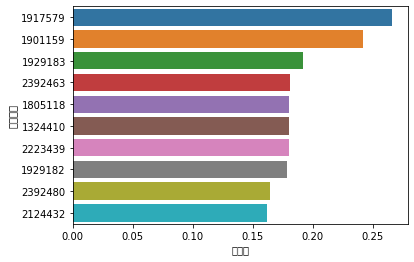

[452 152 699 182 157 492 204 442 532 412]
[0.27650695 0.24005915 0.20672569 0.20672569 0.20572316 0.19459361
 0.19459361 0.17912294 0.17832313 0.17203258]


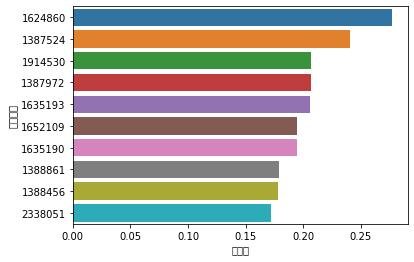

[385 771 718 780 337 774 805 607 600 369]
[0.24871308 0.24871308 0.24871308 0.24335513 0.24101202 0.2396293
 0.22958364 0.21888661 0.21573885 0.21562756]


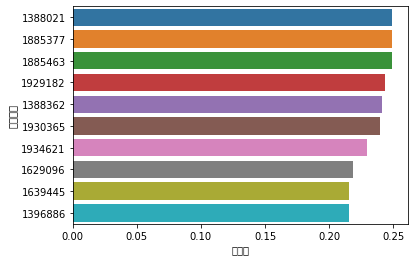

[825 230 706 162 428 393  39 177 465 659]
[0.18797846 0.18327586 0.15174021 0.14899131 0.14414286 0.14278529
 0.13900223 0.13900223 0.13900223 0.13857165]


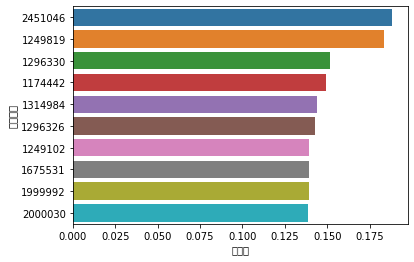

In [ ]:
code1 = vect_count(df_curating_11, 0)
code2 = vect_count(df_curating_22, 1)
code3 = vect_count(df_curating_33, 2)
code4 = vect_count(df_curating_44, 3)

In [ ]:
code_list = [code1, code2, code3, code4]

for idx, code in enumerate(code_list):
  print('')
  print(idx + 1, '분기')
  for num in code.tolist():
    print(get_title(num))
  


1 분기
올마이티 팬츠 [다크 그레이]
플리츠 와이드 밴딩 팬츠 [블랙]
우먼즈 페이퍼백 스트링 미디 스커트 [라이트 베이지]
우먼즈 스웨트 쇼츠 [오트밀]
우먼즈 스웨트 팬츠 [오트밀]
우먼즈 스웨트 팬츠 [블랙]
우먼즈 스웨트 팬츠 [헤더 베이지]
우먼즈 하이 웨이스트 이지 쇼츠 [더스티 핑크]
우먼즈 스웨트 맥시 스커트 [네이비]
우먼즈 릴렉스드 맘 핏 데님 팬츠 [크림]

2 분기
오버사이즈 비건 레더 셔츠 [블랙]
슬릿 넥 피케 폴로 셔츠 [블랙]
릴렉스 핏 피케 폴로 셔츠 [그레이]
릴렉스 핏 피케 폴로 셔츠 [블랙]
레더 코트 스니커즈 [화이트]
독일군 스니커즈 [올 화이트]
독일군 스니커즈 [오프 화이트]
릴렉스드 쇼트 슬리브 셔츠 [네이비]
우먼즈 릴렉스드 쇼트 슬리브 셔츠 [라이트 카키]
무신사 스탠다드 바이 수향 디퓨저 200ml

3 분기
우먼즈 텐셀 실키 반팔 티셔츠 [블랙]
우먼즈 텐셀 실키 반팔 티셔츠 [더스티 베이지]
우먼즈 텐셀 실키 긴팔 티셔츠 [더스티 베이지]
우먼즈 하이 웨이스트 이지 쇼츠 [더스티 핑크]
우먼즈 텐셀 실키 긴팔 티셔츠 [블랙]
우먼즈 베이식 블라우스  [크림]
우먼즈 플로럴 미니 원피스 [블랙]
우먼즈 텐셀 와이넥 긴팔 티셔츠 [블랙]
우먼즈 텐셀 슬림 터틀 넥 티셔츠 [블랙]
우먼즈 리브드 슬림 핏 반팔 티셔츠 [블랙]

4 분기
쿨탠다드 티셔츠 팩 + 삼성 비스포크 큐브냉장고
무신사 스탠다드 핫 팩 10팩 [블랙]
라이트웨이트 배기 드로스트링 밴딩 크롭 슬랙스 [라이트 베이지]
와이드 이지 밴딩 크롭 슬랙스 [블랙]
라이트웨이트 와이드 드로스트링 밴딩 크롭 슬랙스 [라이트 베이지]
라이트웨이트 배기 드로스트링 밴딩 크롭 슬랙스 [블랙]
와이드 히든 밴딩 슬랙스 [더스티 베이지]
와이드 히든 밴딩 슬랙스 [라이트 베이지]
와이드 히든 밴딩 슬랙스 [더스티 크림]
스키니 히든 밴딩 크롭 슬랙스 [크림]
